<a href="https://colab.research.google.com/github/arjiomega/Store-Sales-Forecasting-Model-Decay-Simulation/blob/main/notebooks/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependencies

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Setting up directories
PROJECT_DIR = "../"
DATA_DIR = Path(PROJECT_DIR, "data")
RAW_DATA_DIR = Path(DATA_DIR, "raw")
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Files
train_path = Path(RAW_DATA_DIR,"train.csv")
oil_path = Path(RAW_DATA_DIR,"oil.csv")
stores_path = Path(RAW_DATA_DIR,"stores.csv")
transactions_path = Path(RAW_DATA_DIR,"transactions.csv")
holidays_path = Path(RAW_DATA_DIR,"holidays_events.csv")

## Load Data

**TRAIN SET:**
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

In [ ]:
store_sales_df = pd.read_csv(train_path,index_col="id",parse_dates=["date"])
store_sales_df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


**OIL SET:**

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [ ]:
oil_df = pd.read_csv(oil_path,parse_dates=["date"])
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


**STORES SET:**

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.


In [ ]:
stores_df = pd.read_csv(stores_path)
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


**TRANSACTIONS SET:**

In [ ]:
transactions_df = pd.read_csv(transactions_path,parse_dates=["date"])
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


**HOLIDAYS SET:**

In [ ]:
holidays_df = pd.read_csv(holidays_path,parse_dates=["date"])
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Split Dataset

We do not want to experience data leakage by including validation set or unseen information during exploratory data analysis so we need to split them before we proceed.

In [ ]:
train_df = store_sales_df[store_sales_df.date.dt.year <= 2015].copy()
valid_df = store_sales_df[store_sales_df.date.dt.year > 2015].copy()

## Exploratory Data Analysis

### Store Sales

In [ ]:
train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
1945939,2015-12-31,9,POULTRY,734.391,0
1945940,2015-12-31,9,PREPARED FOODS,98.888,0
1945941,2015-12-31,9,PRODUCE,2888.340,0


In [ ]:
# feature data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1945944 entries, 0 to 1945943
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 89.1+ MB


From the information below we found out that in the data we have there are 54 unique stores.

In [ ]:
# Unique Stores
train_df.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [ ]:
# Unique Product Family
train_df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

From what we can see on the histogram below, it seems that something may be wrong in the distribution. Let us view the sales based on the product family for each store.

<Axes: >

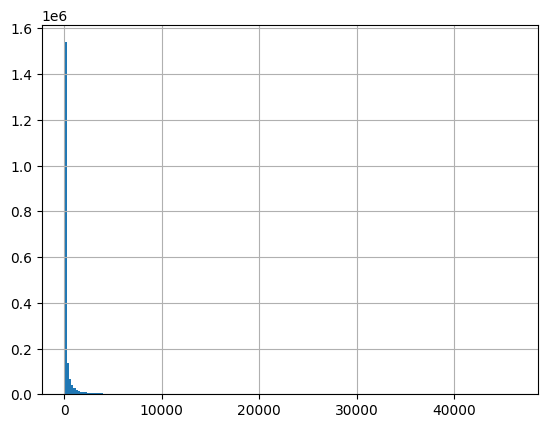

In [ ]:
# Sales
train_df.sales.hist(bins=200)

From the char below, we can see that some product families do not have any sales throughout the years. Let us exclude those families from our analysis.

<Axes: xlabel='family'>

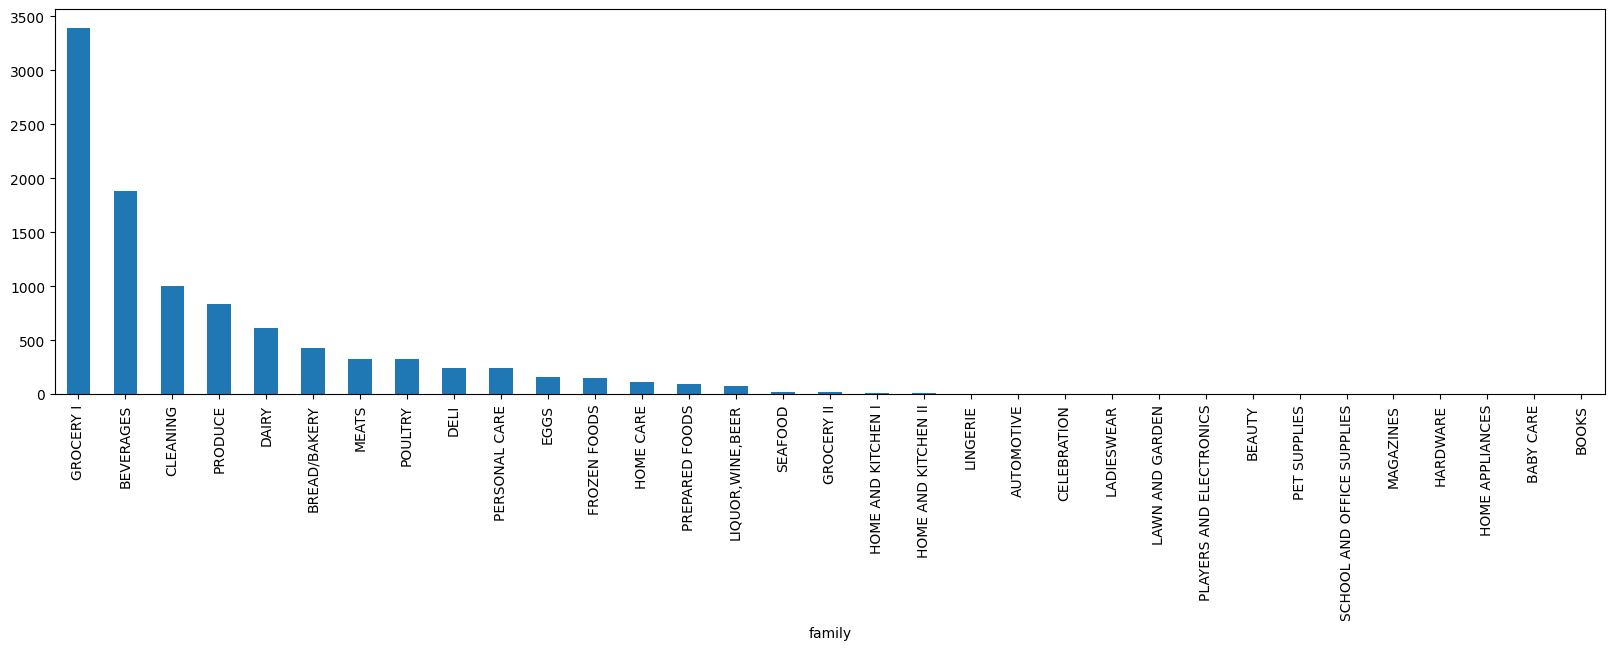

In [ ]:
train_df.groupby("family").sales.mean().sort_values(ascending=False).plot.bar(figsize=(20,5))

In [ ]:
HIGH_SALES_FAMILIES = ["GROCERY I", "BEVERAGES", "CLEANING", "PRODUCE", "DAIRY", "BREAD/BAKERY","MEATS","POULTRY","DELI","PERSONAL CARE","EGGS","FROZEN FOODS","LIQUOR,WINE,BEER"]

<Axes: xlabel='family'>

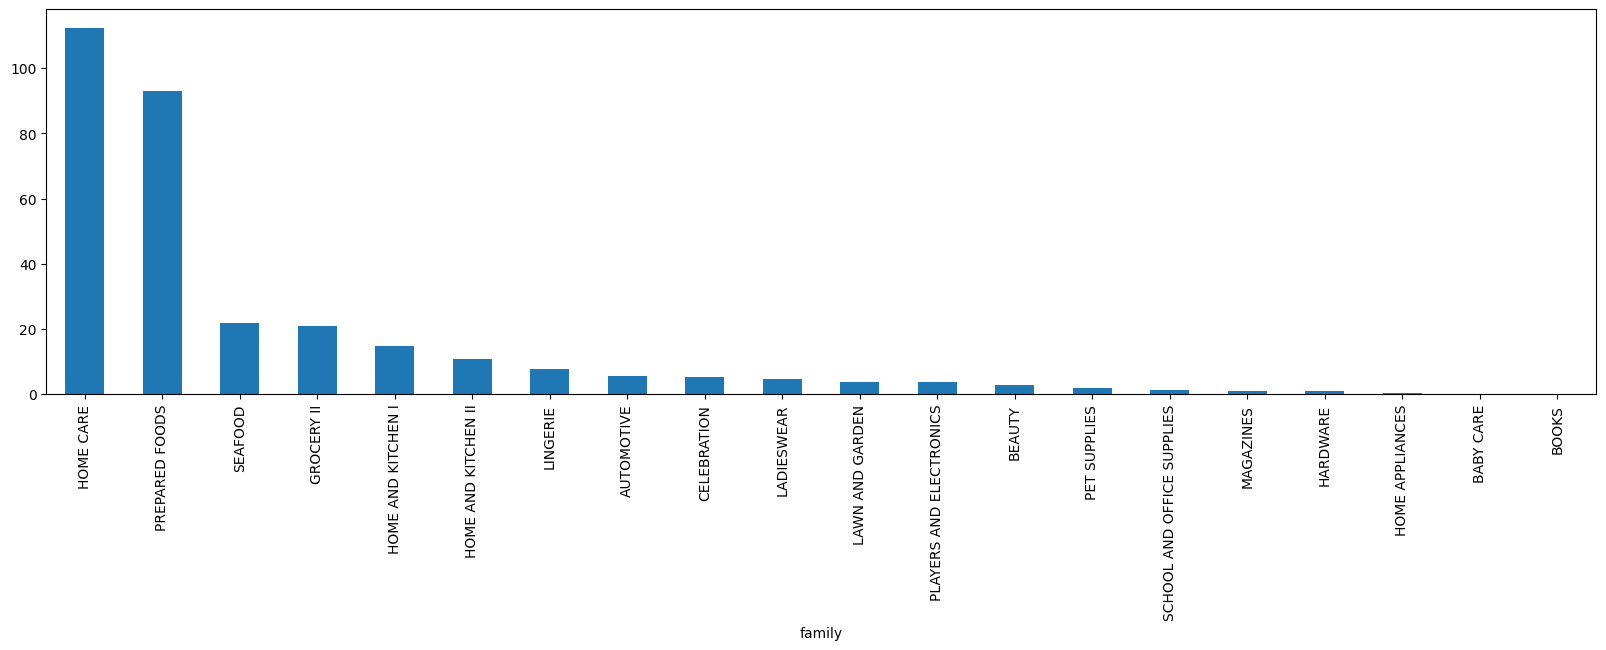

In [ ]:
train_df[~train_df['family'].isin(HIGH_SALES_FAMILIES)].groupby("family").sales.mean().sort_values(ascending=False).plot.bar(figsize=(20,5))

Visualize number of nonzero sales for each product family

In [ ]:
train_df_nonzeros = train_df[train_df.sales > 0]

<Axes: xlabel='family'>

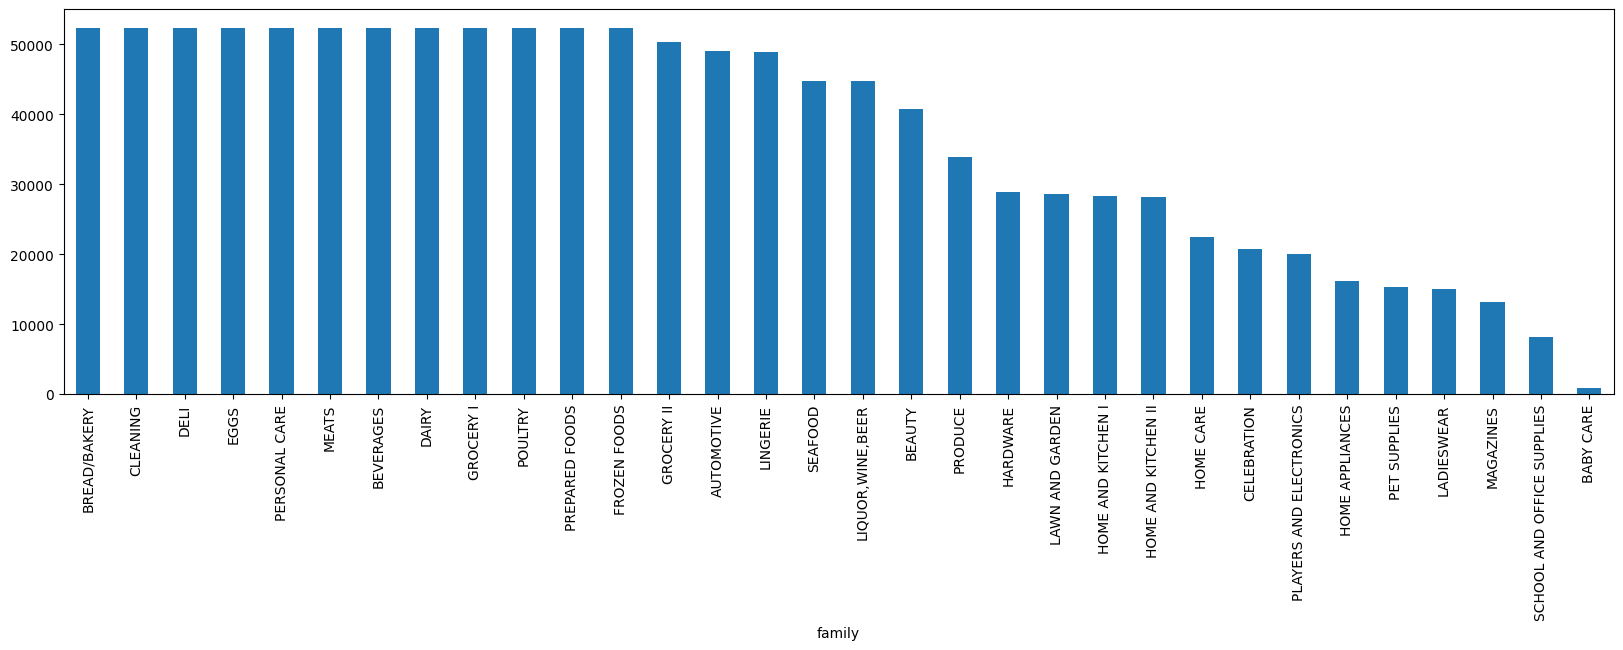

In [ ]:
train_df_nonzeros.groupby("family").count().sales.sort_values(ascending=False).plot.bar(figsize=(20,5))

#### Sales for each product family

We can see in the boxplot below that there are some outliers in the data. We need to get a better understanding first before we decide if we need to remove them because those outliers may be from holidays, promotions, location, etc.

**Automotive**

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

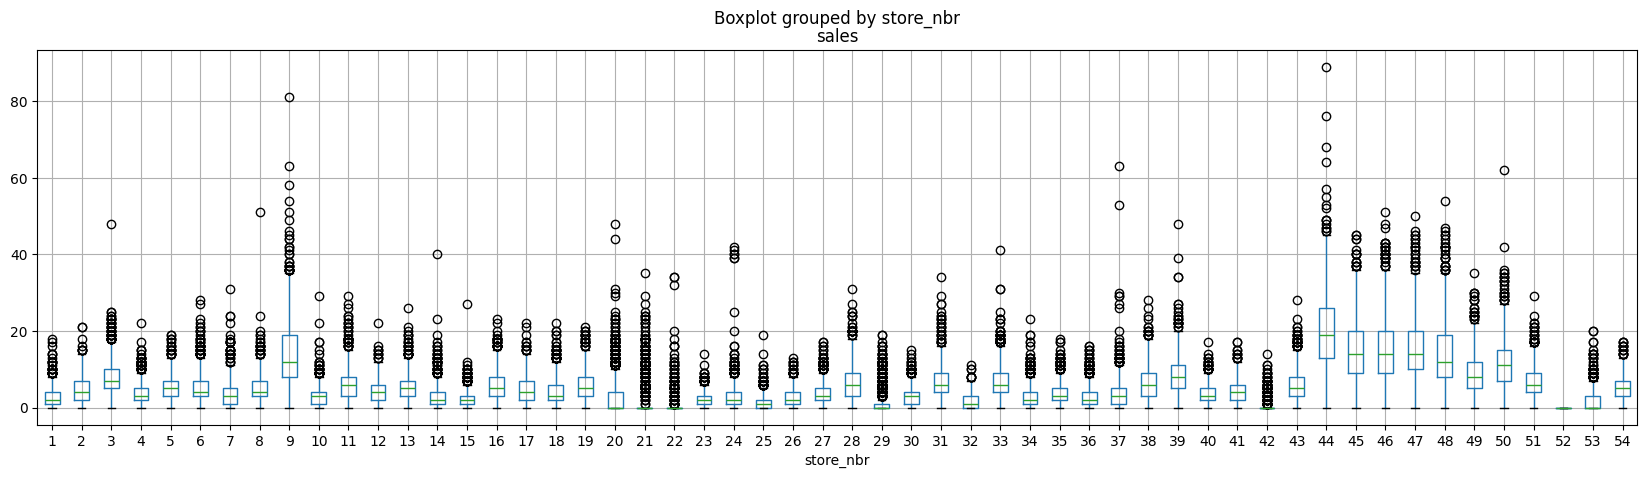

In [ ]:
automotive_df = train_df[train_df.family == "AUTOMOTIVE"]
automotive_df.boxplot(column="sales",by="store_nbr",figsize=(20,5))

**Baby Care**

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

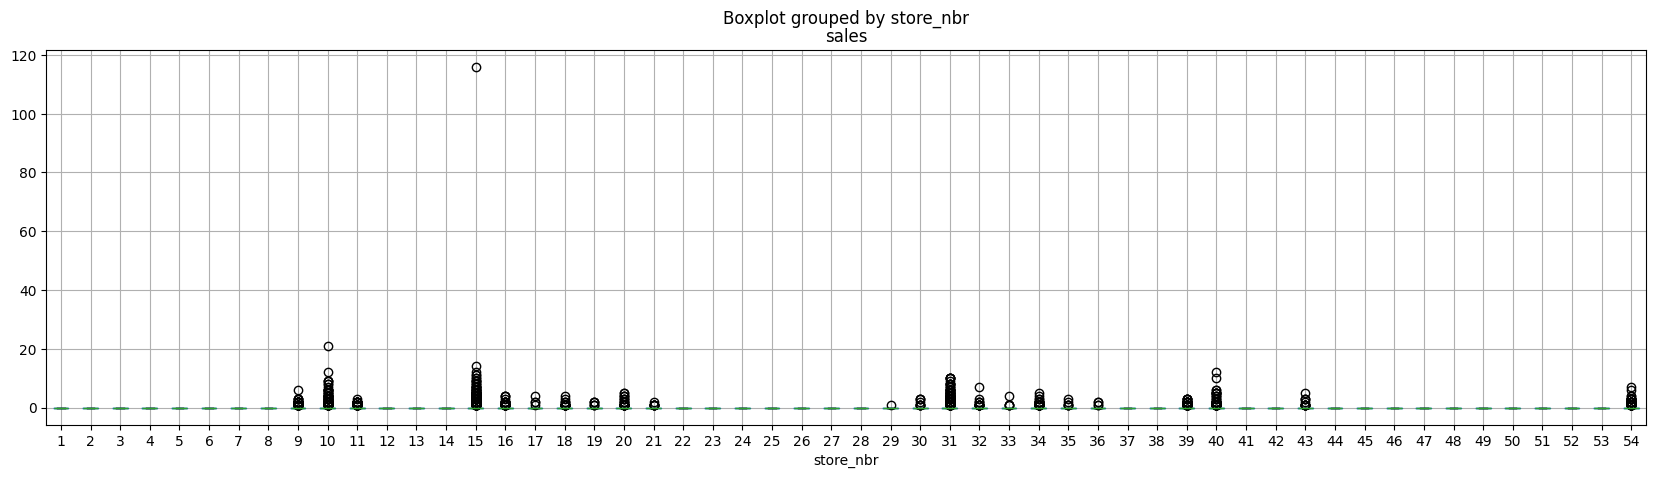

In [ ]:
babycare_df = train_df[train_df.family == "BABY CARE"]
babycare_df.boxplot(column="sales",by="store_nbr",figsize=(20,5))

Most stores seems to have zero baby care product sales.

In [ ]:
babycare_df.describe()

,date,store_nbr,sales,onpromotion
count,58968,58968.000000,58968.000000,58968.000000
mean,2014-07-01 12:23:44.175824128,27.500000,0.036427,0.000017
min,2013-01-01 00:00:00,1.000000,0.000000,0.000000
25%,2013-09-30 18:00:00,14.000000,0.000000,0.000000
50%,2014-07-01 12:00:00,27.500000,0.000000,0.000000
75%,2015-04-01 06:00:00,41.000000,0.000000,0.000000
max,2015-12-31 00:00:00,54.000000,116.000000,1.000000
std,NaN,15.585916,0.613246,0.004118


From what we see below, the sales for baby care products that are non-zeroes normally ranges between 0 to 3.

In [ ]:
babycare_df[babycare_df.sales > 0].describe()

,date,store_nbr,sales,onpromotion
count,846,846.000000,846.000000,846.000000
mean,2015-05-01 06:09:21.702127616,24.489362,2.539007,0.001182
min,2014-03-01 00:00:00,9.000000,1.000000,0.000000
25%,2014-10-29 18:00:00,11.000000,1.000000,0.000000
50%,2015-07-20 12:00:00,19.000000,2.000000,0.000000
75%,2015-09-12 00:00:00,34.000000,3.000000,0.000000
max,2015-12-31 00:00:00,54.000000,116.000000,1.000000
std,NaN,13.538960,4.458913,0.034381


In [ ]:
babycare_df[babycare_df.sales > 50]

,date,store_nbr,family,sales,onpromotion
id,,,,,
1680625,2015-08-04,15,BABY CARE,116.0,0


Out of all the data in babycare_df, only 846 rows have nonzero sales.

**Beauty**

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

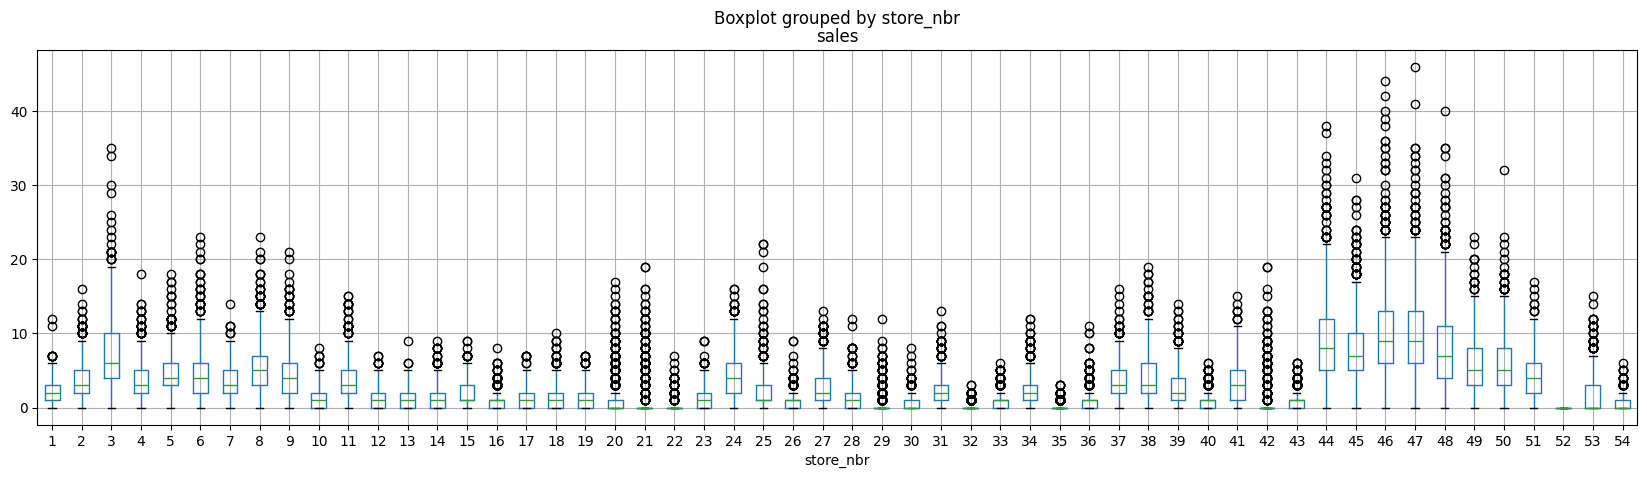

In [ ]:
beauty_df = train_df[train_df.family == "BEAUTY"]
beauty_df.boxplot(column="sales",by="store_nbr",figsize=(20,5))

**Beverages**

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

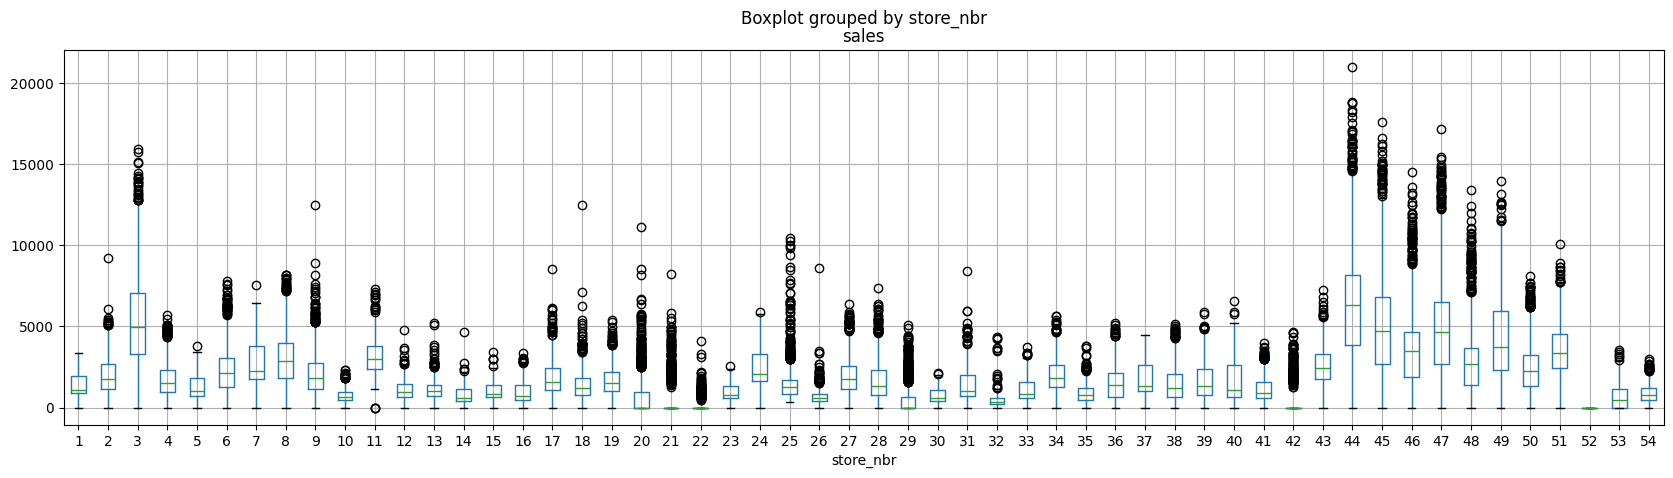

In [ ]:
beverages_df = train_df[train_df.family == "BEVERAGES"]
beverages_df.boxplot(column="sales",by="store_nbr",figsize=(20,5))

**Books**

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

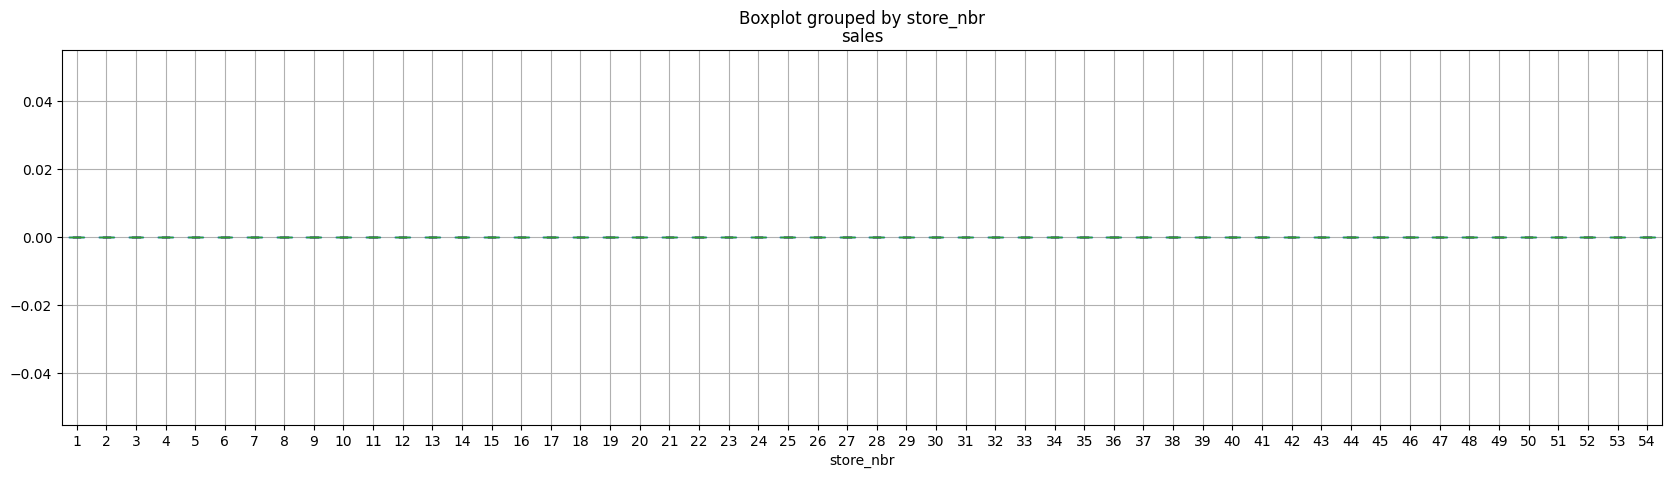

In [ ]:
books_df = train_df[train_df.family == "BOOKS"]
books_df.boxplot(column="sales",by="store_nbr",figsize=(20,5))

There seems to be no sales in books for all the stores.

In [ ]:
books_df.describe()

,date,store_nbr,sales,onpromotion
count,58968,58968.000000,58968.0,58968.0
mean,2014-07-01 12:23:44.175824128,27.500000,0.0,0.0
min,2013-01-01 00:00:00,1.000000,0.0,0.0
25%,2013-09-30 18:00:00,14.000000,0.0,0.0
50%,2014-07-01 12:00:00,27.500000,0.0,0.0
75%,2015-04-01 06:00:00,41.000000,0.0,0.0
max,2015-12-31 00:00:00,54.000000,0.0,0.0
std,NaN,15.585916,0.0,0.0


**BREAD/BAKERY**

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

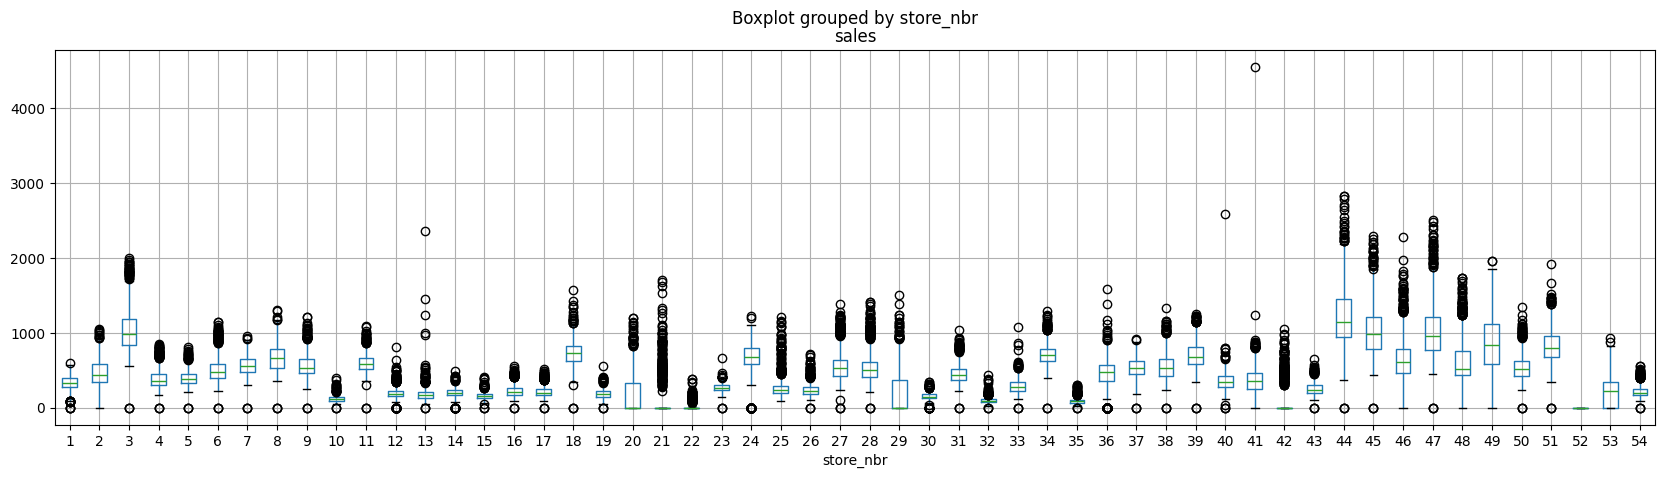

In [ ]:
bakery_df = train_df[train_df.family == "BREAD/BAKERY"]
bakery_df.boxplot(column="sales",by="store_nbr",figsize=(20,5))

## Combine Data

In [ ]:
def combine_data(
    store_sales: pd.DataFrame,
    store_info: pd.DataFrame,
    oil_prices: pd.DataFrame,
    local_holidays: pd.DataFrame,
    national_holidays: pd.DataFrame,
    regional_holidays: pd.DataFrame
    ) -> pd.DataFrame:
    """Combine multiple dataframes into a single dataframe.

    Args:
        store_sales (pd.DataFrame): daily sales of a product family at a particular
                                    store including the number of products on promotion.
        store_info (pd.DataFrame): stores' location information.
        oil_prices (pd.DataFrame): oil prices per day in Ecuador.
        local_holidays (pd.DataFrame): local holidays in Ecuador.
        national_holidays (pd.DataFrame): national holidays in Ecuador.
        regional_holidays (pd.DataFrame): regional holidays in Ecuador.
    """
    merge_1 = pd.merge(store_sales, oil_prices, on="date", how="left")
    merge_2 = pd.merge(merge_1, store_info, on="store_nbr", how="left")
    merge_3 = pd.merge(merge_2, national_holidays, on="date", how="left")
    merge_4 = pd.merge(merge_3, local_holidays, on=["date", "city"], how="left")
    combined_df = pd.merge(merge_4, regional_holidays, on=["date", "state"], how="left")

    return combined_df

In [ ]:
combine_df = combine_data(
    store_sales=store_sales_df,
    store_info=stores_df,
    oil_prices=oil_df,
    holidays=holidays_df,
)

TypeError: combine_data() got an unexpected keyword argument 'holidays'